In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.models import model_ND
from scipy.optimize import minimize

## Heat input function

In [58]:
func_Q_in = lambda x: (1 + 0.5*np.sin(2*np.pi*x/(3600*12))) #

We are able to recover the desired heat capacity, thermal conductivity and initial temperature even with pretty bad intial guesses. However, need to ensure intial guesses are at least on the right order of magnitude.

## 2 Segments

(<Figure size 1440x720 with 2 Axes>,
 <AxesSubplot:xlabel='Time (hours)', ylabel='Temperature (C)'>)

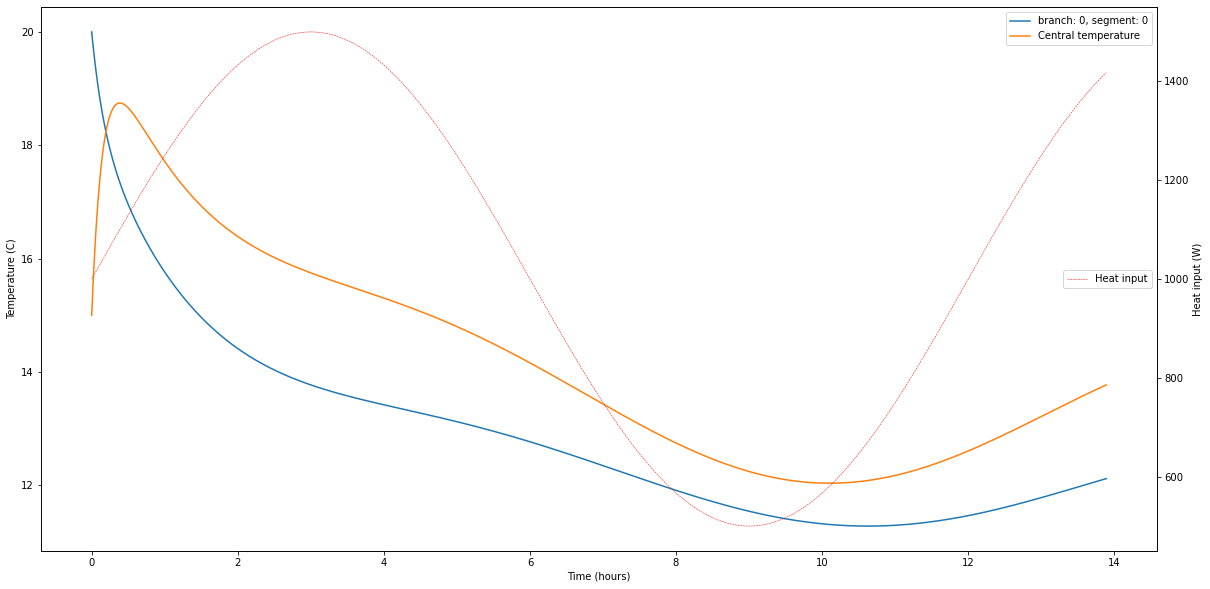

In [59]:
k = [800.0, 500.0]
c = [6e5, 2.5e6]
T = [15.0, 20.0]
true_params = np.array([*k, *c, *T])
T_out = 10
heatinput = 1000
iterations = 1000
# Initialise class with system parameters
sys_nd = model_ND(k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 5e4, iterations+1)
Ts_true, Qs = sys_nd.run(times=times, func_Q_in=func_Q_in)
sys_nd.plot()

In [60]:
def loss(params):
    
    # This loss function needs to be a lot faster as it will be called many times by scipy minimize
    
    T_out = 10
#     k_est, c_est, T_est = params
    k1, k2, c1, c2, T1, T2 = params
    
    k_est = np.array([k1,k2]).reshape(1,-1)
    c_est = np.array([c1,c2]).reshape(1,-1)
    T_est = np.array([T1,T2]).reshape(1,-1)
    
    times = np.linspace(0, 5e4, iterations+1)
    T_out = np.array(T_out).reshape(-1,1)
    Ts = np.empty(shape=(len(times), 1, 2))
    Ts[0] = T_est
    Q_in = 1000
    
    dtimes = np.diff(times)
    for i in range(len(times)-1):
        
        heat_flux = np.diff(np.hstack((T_est,T_out)))*k_est
        net_heat_flux = np.diff(heat_flux)
        
        # update non central nodes
        T_est[:, 1:] += ( net_heat_flux / c_est[:,1:] ) * dtimes[i]
        
        # update central node
        T_est[:, 0] += ( (heat_flux[:,0] + Q_in) / c_est[:,0] ).sum() * dtimes[i]
    
        Ts[i+1] = T_est

    Ts = np.transpose(Ts,axes=(1,2,0)) # New shape has (n_branches, n_segments, n_iterations)
    
    return np.mean((Ts_true - Ts) ** 2)

In [61]:
def profile(params):
    
    T_out = 10
    k1, k2, c1, c2, T1, T2 = params
    
    k_est = np.array([k1,k2]).reshape(1,-1)
    c_est = np.array([c1,c2]).reshape(1,-1)
    T_est = np.array([T1,T2]).reshape(1,-1)
    
    times = np.linspace(0, 5e4, iterations+1)
    T_out = np.array(T_out).reshape(-1,1)
    Ts = np.empty(shape=(len(times), 1, 2))
    Ts[0] = T_est
    Q_in_mag = 1000
    
    
    
    
    dtimes = np.diff(times)
    for i, t in enumerate(times[1:]):
        Q_in = Q_in_mag * func_Q_in(t)
        
        heat_flux = np.diff(np.hstack((T_est,T_out)))*k_est
        net_heat_flux = np.diff(heat_flux)
        
        # update non central nodes
        T_est[:, 1:] += ( net_heat_flux / c_est[:,1:] ) * dtimes[i]
        
        # update central node
        T_est[:, 0] += ( (heat_flux[:,0] + Q_in) / c_est[:,0] ).sum() * dtimes[i]
    
        Ts[i+1] = T_est

    Ts = np.transpose(Ts,axes=(1,2,0)) # New shape has (n_branches, n_segments, n_iterations)
    
    return Ts

In [62]:
# Initial guesses for scipy.optimize.minimize
k0 = [800.0, 500.0]
c0 = [1e5, 1e6]
T0 = [14.0, 15.0]
params = np.array([*k0, *c0, *T0])
mse = loss(params)

Now we need to fit both functions

In [63]:
result = minimize(loss, x0=params)

In [64]:
result['x']

array([9.13944628e+02, 3.73068604e+02, 1.00001320e+05, 1.00000077e+06,
       1.24681883e+01, 2.16827310e+01])

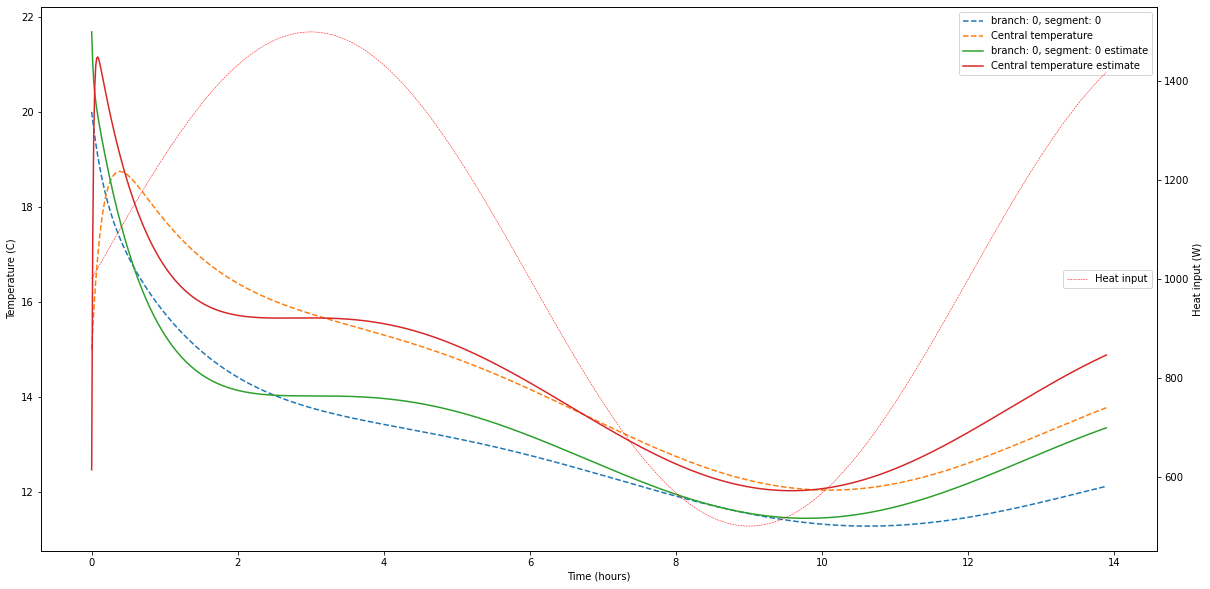

In [65]:
# Plot estimated heating profile
fig, ax = sys_nd.plot(ls='--')
Ts_est = profile(result['x'])
for i, T_br in enumerate(Ts_est):
    for j, T_seg in enumerate(T_br[1:]):
        ax.plot(times/3600, T_seg, label='branch: {}, segment: {} estimate'.format(i,j))
ax.plot(times/3600, Ts_est[0,0,:], label='Central temperature estimate')
ax.legend()

In [66]:
frac_error = abs((result['x'] - true_params)/true_params * 100)

In [67]:
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))





Percentage error:
k1:		14.24%		k2:		25.39%
c1:		83.33%		c2:		60.00%
T1_initial:	16.88%		T2_initial:	8.41%


Is the jacobian the error on each parameter? Need to investigate.

In [68]:
result['jac']

array([ 5.66244125e-07,  2.39908695e-06, -1.62422657e-06, -8.19563866e-07,
        9.83476639e-07, -7.74860382e-07])